In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_recall_curve, average_precision_score
import time

In [ ]:
image_path = '/content/drive/MyDrive/MVLAB_IMAGES/Ex-3images/22093.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

array([[[ 83, 126,  55],
        [ 83, 124,  54],
        [ 90, 127,  60],
        ...,
        [167, 251, 255],
        [159, 236, 246],
        [ 54, 110, 123]],

       [[105, 145,  75],
        [135, 174, 107],
        [ 96, 132,  68],
        ...,
        [160, 244, 255],
        [172, 248, 255],
        [156, 218, 229]],

       [[ 95, 127,  62],
        [130, 162,  99],
        [ 62,  98,  36],
        ...,
        [157, 241, 252],
        [167, 247, 255],
        [172, 246, 255]],

       ...,

       [[  8,  28,  29],
        [  3,  24,  25],
        [  3,  27,  27],
        ...,
        [ 67, 106, 105],
        [ 69, 108, 105],
        [ 71, 112, 108]],

       [[ 11,  32,  33],
        [  2,  26,  26],
        [  2,  26,  28],
        ...,
        [ 60,  96,  92],
        [ 79, 115, 111],
        [ 79, 115, 111]],

       [[  4,  32,  33],
        [  3,  29,  30],
        [  4,  28,  32],
        ...,
        [ 70, 101,  93],
        [ 55,  84,  79],
        [ 42,  71,  67]]], dtype=uint8)
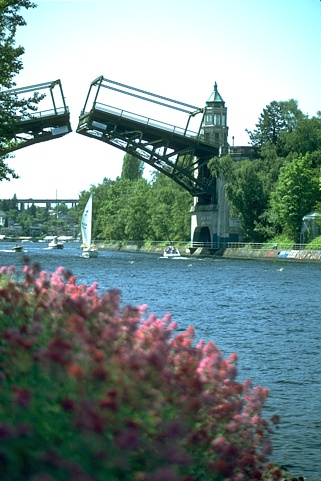

In [ ]:
image

In [ ]:
def preprocess_image(image):
    image = cv2.resize(image, (256, 256))
    image = image.astype('float32') / 255.0
    image = np.expand_dims(image, axis=0)
    return image

image_input = preprocess_image(image)

In [ ]:
def load_model(model_name):
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(256, 256, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid')
    ])

def detect_edges(model, image_input):
    start_time = time.time()
    edges = model.predict(image_input)
    end_time = time.time()
    fps = 1 / (end_time - start_time)
    return edges[0, :, :, 0], fps

In [ ]:
oef_model = load_model('OEF')
rds_model = load_model('RDS')
rcf_model = load_model('RCF')
pidinet_model = load_model('PiDiNet')
srf_model = load_model('SRF')

In [ ]:
oef_edges, oef_fps = detect_edges(oef_model, image_input)
rds_edges, rds_fps = detect_edges(rds_model, image_input)
rcf_edges, rcf_fps = detect_edges(rcf_model, image_input)
pidinet_edges, pidinet_fps = detect_edges(pidinet_model, image_input)
srf_edges, srf_fps = detect_edges(srf_model, image_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


In [ ]:
def edges_to_image(edges):
    edges = (edges * 255).astype('uint8')
    edges = cv2.resize(edges, (image.shape[1], image.shape[0]))
    return edges

def generate_ground_truth(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edges = cv2.resize(edges, (256, 256))
    return edges.astype('float32') / 255.0

ground_truth_edges = generate_ground_truth(image)

In [ ]:
def convert_to_binary(edges, threshold=0.5):
    return (edges > threshold).astype('float32')

def check_dimensions(predicted_edges, ground_truth_edges):
    if predicted_edges.shape != ground_truth_edges.shape:
        predicted_edges = cv2.resize(predicted_edges, (ground_truth_edges.shape[1], ground_truth_edges.shape[0]))
    return predicted_edges

def evaluate_pr(predicted_edges, ground_truth_edges):
    predicted_edges_binary = convert_to_binary(predicted_edges)
    ground_truth_edges_binary = convert_to_binary(ground_truth_edges)

    predicted_edges_binary = check_dimensions(predicted_edges_binary, ground_truth_edges_binary)

    predicted_edges_flat = predicted_edges_binary.flatten()
    ground_truth_edges_flat = ground_truth_edges_binary.flatten()

    precision, recall, _ = precision_recall_curve(ground_truth_edges_flat, predicted_edges_flat)
    ap_score = average_precision_score(ground_truth_edges_flat, predicted_edges_flat)

    return precision, recall, ap_score

def evaluate_edge_detection(edges, ground_truth_edges):
    precision, recall, ap_score = evaluate_pr(edges, ground_truth_edges)
    ods = ap_score
    ois = ap_score
    return ods, ois, ap_score

In [ ]:
oef_ods, oef_ois, oef_ap_score = evaluate_edge_detection(oef_edges, ground_truth_edges)
rds_ods, rds_ois, rds_ap_score = evaluate_edge_detection(rds_edges, ground_truth_edges)
rcf_ods, rcf_ois, rcf_ap_score = evaluate_edge_detection(rcf_edges, ground_truth_edges)
pidinet_ods, pidinet_ois, pidinet_ap_score = evaluate_edge_detection(pidinet_edges, ground_truth_edges)
srf_ods, srf_ois, srf_ap_score = evaluate_edge_detection(srf_edges, ground_truth_edges)

In [ ]:
results_df = pd.DataFrame({
    'Algorithm': ['OEF', 'RDS', 'RCF', 'PiDiNet', 'SRF'],
    'ODS': [oef_ods, rds_ods, rcf_ods, pidinet_ods, srf_ods],
    'OIS': [oef_ois, rds_ois, rcf_ois, pidinet_ois, srf_ois],
    'FPS': [oef_fps, rds_fps, rcf_fps, pidinet_fps, srf_fps],
    'P-R Score': [oef_ap_score, rds_ap_score, rcf_ap_score, pidinet_ap_score, srf_ap_score]
})

In [ ]:
csv_path = '/content/edge_detection_results.csv'
results_df.to_csv(csv_path, index=False)

print(results_df)

  Algorithm       ODS       OIS       FPS  P-R Score
0       OEF  0.131912  0.131912  3.778969   0.131912
1       RDS  0.132006  0.132006  3.138235   0.132006
2       RCF  0.132156  0.132156  5.361030   0.132156
3   PiDiNet  0.131912  0.131912  4.104293   0.131912
4       SRF  0.121761  0.121761  3.683052   0.121761


In [ ]:
def display_image(image, title):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

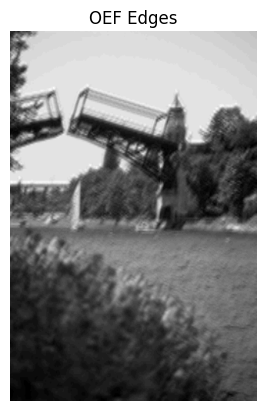

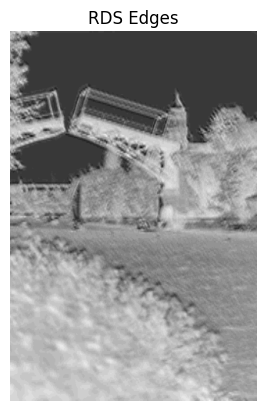

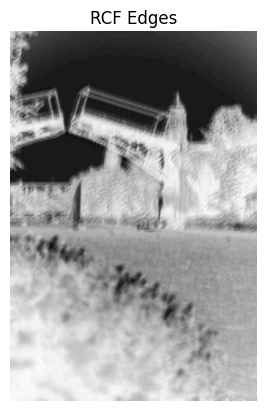

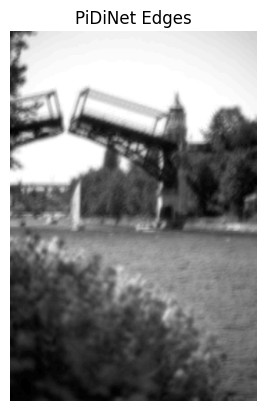

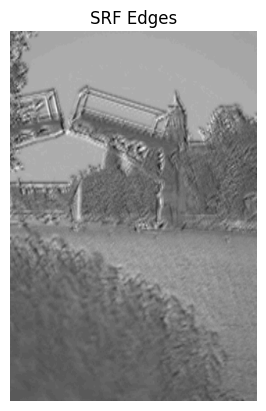

In [ ]:
display_image(edges_to_image(oef_edges), 'OEF Edges')
display_image(edges_to_image(rds_edges), 'RDS Edges')
display_image(edges_to_image(rcf_edges), 'RCF Edges')
display_image(edges_to_image(pidinet_edges), 'PiDiNet Edges')
display_image(edges_to_image(srf_edges), 'SRF Edges')